In [43]:
import cv2 as cv
import numpy as np
import skimage
import matplotlib.pyplot as plt

In [44]:
# Implementation of MATLAB's imfill(I, 'holes') function
# @param[in] img Image to process
# @return An image with holes removed
def imfill(img):
    if img.ndim != 2 or img.dtype != np.uint8:
        return None
    rows, cols = img.shape[0:2]
    mask = img.copy()
    # Fill mask from all horizontal borders
    for i in range(cols):
        if mask[0, i] == 0:
            cv.floodFill(mask, None, (i, 0), 255, 10, 10)
        if mask[rows - 1, i] == 0:
            cv.floodFill(mask, None, (i, rows - 1), 255, 10, 10)
    # Fill mask from all vertical borders
    for i in range(rows):
        if mask[i, 0] == 0:
            cv.floodFill(mask, None, (0, i), 255, 10, 10)
        if mask[i, cols - 1] == 0:
            cv.floodFill(mask, None, (cols - 1, i), 255, 10, 10)
    # Use the mask to create a resulting image
    res_img = img.copy()
    res_img[mask == 0] = 255
    return res_img

In [45]:
# Remove small objects from binary image
# @param[in] img Input image
# @param[in] dim A minimum size of an area to keep
#
# @param[int] conn Pixel connectivity
# @return An image with components less than dim removed
def bwareaopen(img, dim, conn = 8):
    if img.ndim != 2 or img.dtype != np.uint8:
        return None
    # Find all connected components
    num, labels, stats, centers = cv.connectedComponentsWithStats(img, connectivity=conn)
    # Check size of all connected components
    for i in range(num):
        if stats[i, cv.CC_STAT_AREA] < dim:
            img[labels == i] = 0
    return img

In [46]:
# Reading an image
img_path = "../../images/"
img_name = "satellite_1.jpg"
img = cv.imread(img_path + img_name, cv.IMREAD_COLOR)

True

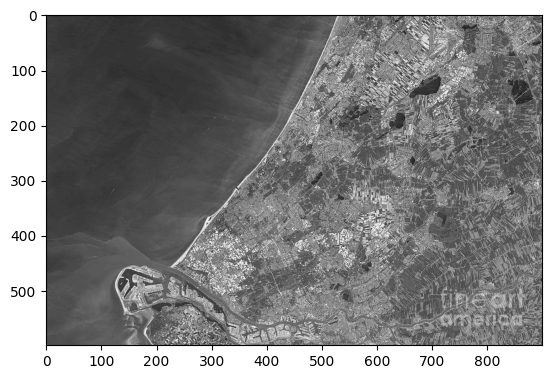

In [47]:
# Convert to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_grayscale.jpg", img_gray)

True

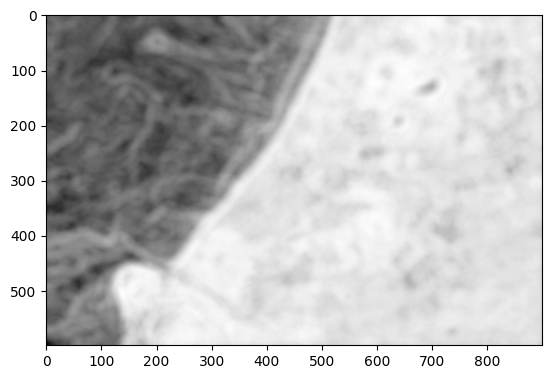

In [48]:
# Calculate entropy and then normalize
ent = skimage.filters.rank.entropy(img_gray, skimage.morphology.disk(13)).astype(np.float32)
ent_norm = (ent - np.min(ent)) / (np.max(ent) - np.min(ent))
plt.imshow(np.uint8(ent_norm * 255), cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_buf.jpg", np.uint8(ent_norm * 255))

True

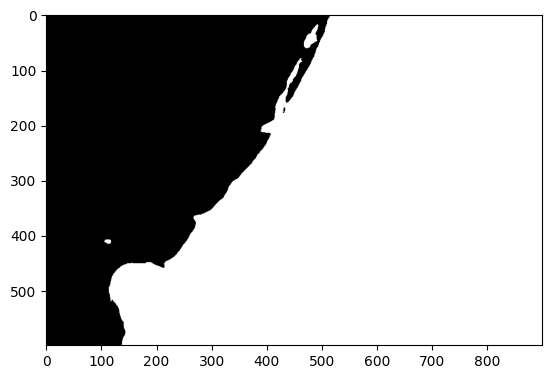

In [49]:
# Binarize the resulting normalized array using the Otsu method
ret, bin_ent = cv.threshold(np.uint8(ent_norm * 255), 0, 255, cv.THRESH_OTSU)
plt.imshow(bin_ent, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_buf.jpg", bin_ent)

Morphological filtering

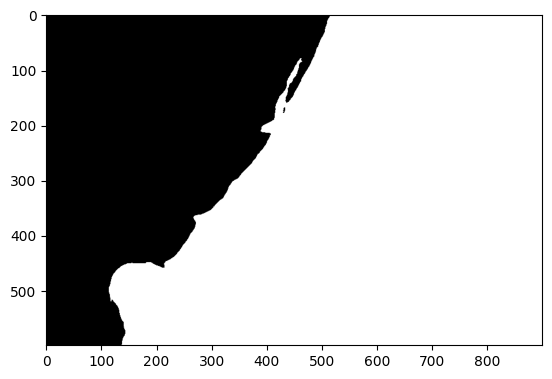

In [50]:
# 1. Remove small objects from binary image
img_fil = bwareaopen(bin_ent, 2000, conn=8)
plt.imshow(img_fil, cmap='gray', vmin=0, vmax=255)

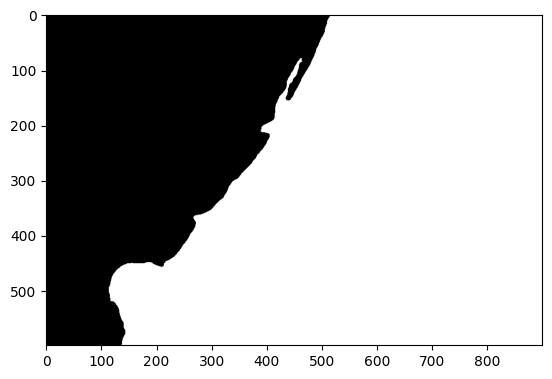

In [51]:
# 2. Remove internal defects with closing operation
el = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9, 9))
img_fil = cv.morphologyEx(img_fil, cv.MORPH_CLOSE, el)
plt.imshow(img_fil, cmap='gray', vmin=0, vmax=255)

True

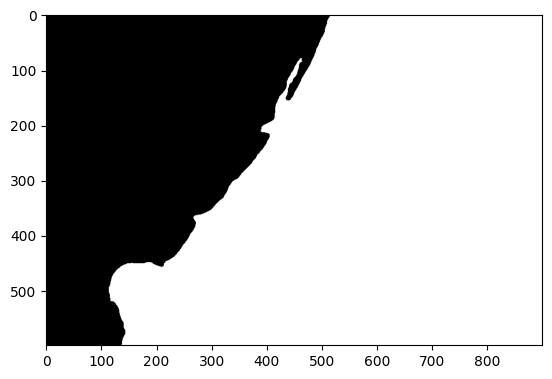

In [52]:
# 3. Fill remaining large holes
img_fil = imfill(img_fil)
plt.imshow(img_fil, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_buf.jpg", img_fil)

True

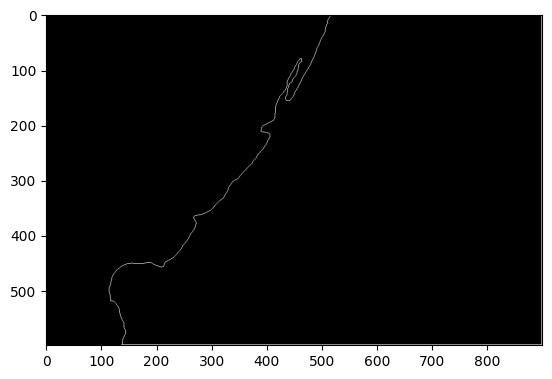

In [53]:
# Find shape contours and then draw them on a black background
contours, h = cv.findContours(img_fil, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
boundary = np.zeros_like(img_gray)
cv.drawContours(boundary, contours, -1, 255, 1)
plt.imshow(boundary, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_buf.jpg", boundary)

True

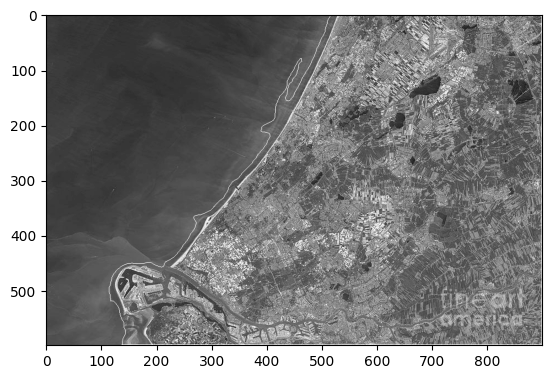

In [54]:
# Apply the found border to the source image
segment_results = img_gray.copy()
segment_results[boundary != 0] = 255
plt.imshow(segment_results, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_111.jpg", segment_results)

True

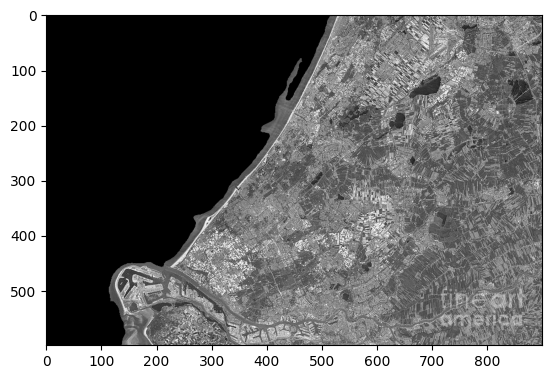

In [55]:
# Excluding the water area from the source image and do the same steps to select the remaining texture of the land
img_gray_2 = img_gray.copy()
img_gray_2[img_fil == 0] = 0
plt.imshow(img_gray_2, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_buf.jpg", img_gray_2)

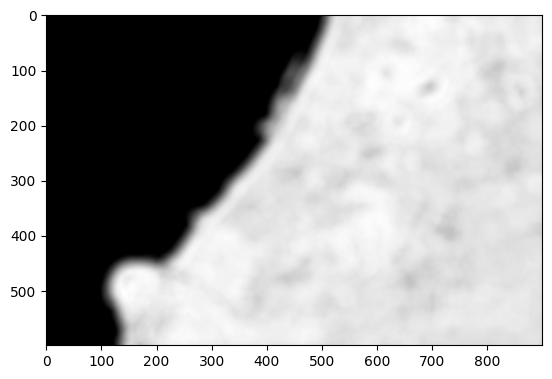

In [56]:
# Entropy
ent_2 = skimage.filters.rank.entropy(img_gray_2, skimage.morphology.disk(17)).astype(np.float32)
ent_norm_2 = (ent_2 - ent_2.min()) / (ent_2.max() - ent_2.min())
plt.imshow(ent_norm_2, 'gray', vmin=0, vmax=1)

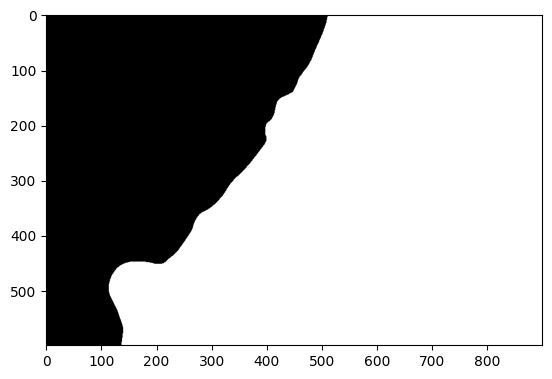

In [57]:
# Binarization
ret_2, bin_ent_2 = cv.threshold(np.uint8(ent_norm_2 * 255), 0, 255, cv.THRESH_OTSU)
plt.imshow(bin_ent_2, 'gray', vmin=0, vmax=255)

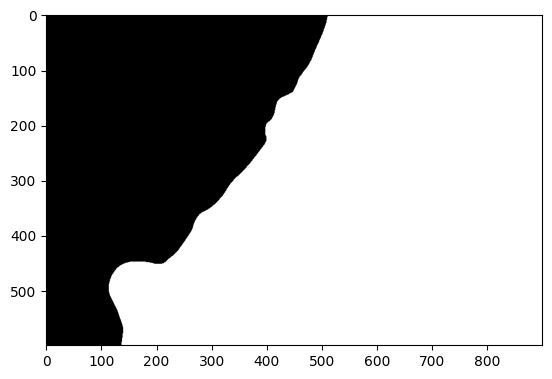

In [58]:
# Filtering
img_fil_2 = bwareaopen(bin_ent_2, 2000, conn=8)
img_fil_2 = cv.morphologyEx(img_fil_2, cv.MORPH_CLOSE, el)
img_fil_2 = imfill(img_fil_2)
plt.imshow(img_fil_2, cmap='gray', vmin=0, vmax=255)

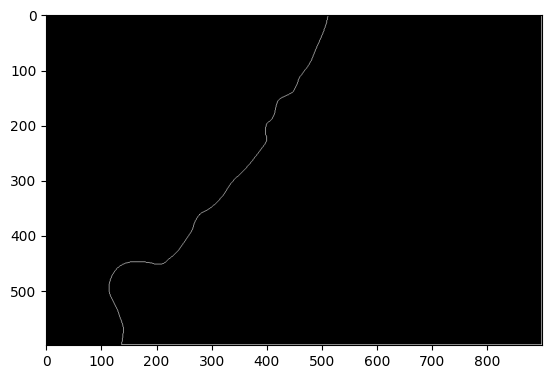

In [59]:
# Select boundary
contours_2, h_2 = cv.findContours(img_fil_2, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
boundary_2 = np.zeros_like(img_gray_2)
cv.drawContours(boundary_2, contours_2, -1, 255, 1)
plt.imshow(boundary_2, cmap='gray', vmin=0, vmax=255)


True

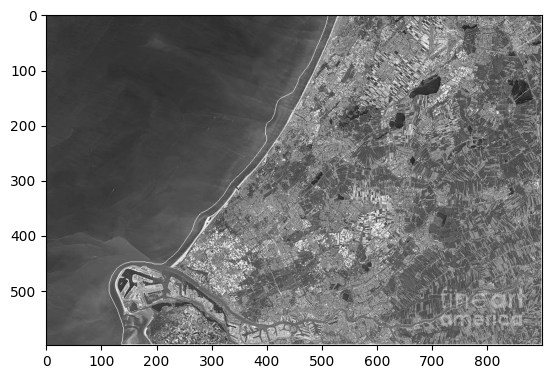

In [63]:
# Apply the found border to the source image
segment_results_2 = img_gray.copy()
segment_results_2[boundary_2 != 0] = 255
plt.imshow(segment_results_2, cmap='gray', vmin=0, vmax=255)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_222.jpg", segment_results_2)

In [61]:
# Select textures of water and land basing on either of masks
texture_1 = img_gray.copy()
texture_1[img_fil_2 == 0] = 0
texture_2 = img_gray.copy()
texture_2[img_fil_2 != 0] = 0

True

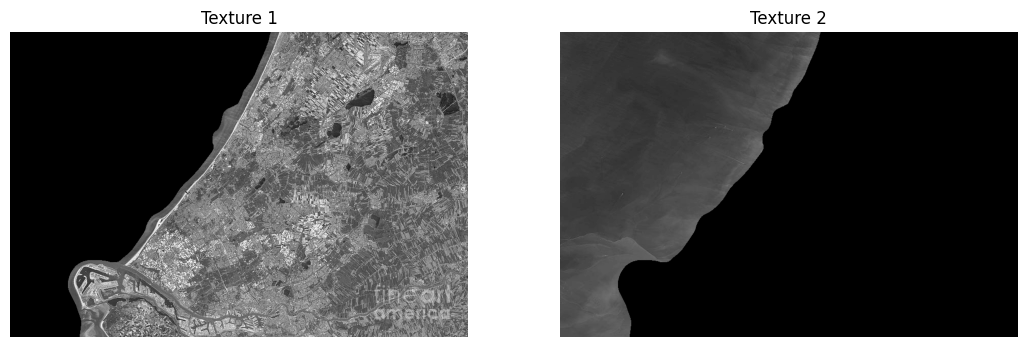

In [64]:
# Show textures
fig = plt.figure(figsize=(13, 9))
fig.add_subplot(1, 2, 1)
plt.imshow(texture_1, cmap='gray', vmin=0, vmax=255)
plt.title("Texture 1")
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(texture_2, cmap='gray', vmin=0, vmax=255)
plt.title("Texture 2")
plt.axis('off')
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_tex1.jpg", texture_1)
cv.imwrite(img_path + img_name.rpartition('.')[0] + "_tex2.jpg", texture_2)

In [72]:
import scipy

In [73]:
# Calculate estimating parameters
# 1. Mean intensity
mean_1 = np.mean(img_gray[img_fil_2 != 0])
mean_2 = np.mean(img_gray[img_fil_2 == 0])
# 2. Standard deviation
std_1 = np.std(img_gray[img_fil_2 != 0])
std_2 = np.std(img_gray[img_fil_2 == 0])
# 3. R - relative smoothness
r_1 = 1 - 1 / (1 + np.power(std_1, 2))
r_2 = 1 - 1 / (1 + np.power(std_2, 2))
# 4. Third central moment
tcm_1 = scipy.stats.moment(img_gray[img_fil_2 != 0], moment=3, axis=0)
tcm_2 = scipy.stats.moment(img_gray[img_fil_2 == 0], moment=3, axis=0)

In [74]:
print(mean_1, mean_2)
print(std_1, std_2)
print(r_1, r_2)
print(tcm_1, tcm_2)

121.43326510578149 67.84391836564389
40.86567634013221 13.616440524471624
0.9994015572089691 0.9946354076176378
43863.71460864429 1919.503639525609


In [90]:
# 5. Histogram homogeneity
hist_1 = cv.calcHist([img_gray[img_fil_2 != 0]], [0], None, [256], (0, 256)) / img_gray[img_fil_2 != 0].size
hist_2 = cv.calcHist([img_gray[img_fil_2 == 0]], [0], None, [256], (0, 256))/ img_gray[img_fil_2 == 0].size
hh_1 = np.sum(np.power(hist_1, 2))
hh_2 = np.sum(np.power(hist_2, 2))

In [91]:
print(hh_1, hh_2)

0.007339712134643115 0.02581271051490213


In [92]:
# 6. Entropy
ent_1 = scipy.stats.entropy(img_gray[img_fil_2 != 0], base=2)
ent_2 = scipy.stats.entropy(img_gray[img_fil_2 == 0], base=2)

In [93]:
print(ent_1, ent_2)

18.325926728478255 17.520710122402235
